In [18]:
import cv2
import numpy as np
import math
import matplotlib.pyplot as plt
import itertools

# PARAMETERS

In [33]:
block=-1
filename='C:/Users/Devanshu/Desktop/My folder/CS517/P3_2021CSB1082_Devanshu/test-images/matches-random.tif'
codesize=32

# LZW ENCODING

In [34]:
img=cv2.imread(filename, 0)
h,w=img.shape

In [35]:
def encode(img, encoding):
    prev=""
    encoded_img=[]
    for i in img.flatten():
            prev=''.join([prev,chr(i)])
            if(prev not in encoding):
                encoded_img.append(encoding[prev[:-1]])
                encoding[prev]=len(encoding)
                prev=chr(i)
    if(prev!=""):
        encoded_img.append(encoding[prev])
    if(max(encoding.values())>2**codesize):
        raise Exception("Encoding is too large")
    return encoded_img

In [36]:
def encode_img(img):
    if block==-1:
        return ([encode(img, encoding={chr(i):i for i in range(0,256)})], img.shape[0],img.shape[1])
    a,b=img.shape[:2]
    if(a//block * block!=a):
        a=math.ceil(a/block)*block
    if(b//block*block!=b):
        b=math.ceil(b/block)*block
    img2=np.zeros((a,b), dtype=np.uint8)
    img2[:img.shape[0],:img.shape[1]]=img
    res=[]
    for i in range(0,a,block):
        for j in range(0,b,block):
            encoding={chr(i):i for i in range(0,256)}
            res.append(encode(img2[i:i+block,j:j+block], encoding))
    return (res,a,b)

In [37]:
encoded_val,a,b=encode_img(img)
n_pixels_uncompressed=h*w
arr=np.concatenate(encoded_val)
n_pixels_compressed=arr.shape[0]
max_encoding_val=np.max(arr)
avg_encoding_val=np.mean(arr)

In [38]:
encoded_val

[[87,
  87,
  61,
  46,
  59,
  74,
  85,
  75,
  53,
  48,
  47,
  66,
  81,
  72,
  59,
  59,
  54,
  66,
  92,
  85,
  74,
  59,
  47,
  67,
  97,
  113,
  100,
  67,
  65,
  65,
  78,
  90,
  97,
  87,
  60,
  54,
  57,
  72,
  82,
  73,
  65,
  64,
  81,
  81,
  104,
  102,
  77,
  58,
  58,
  64,
  92,
  96,
  81,
  62,
  62,
  261,
  90,
  90,
  72,
  51,
  44,
  54,
  77,
  90,
  70,
  55,
  51,
  59,
  78,
  105,
  80,
  80,
  56,
  49,
  56,
  65,
  87,
  81,
  63,
  51,
  60,
  79,
  99,
  97,
  69,
  69,
  60,
  65,
  72,
  90,
  87,
  65,
  55,
  57,
  78,
  110,
  96,
  80,
  73,
  67,
  67,
  76,
  89,
  86,
  77,
  66,
  62,
  340,
  69,
  62,
  56,
  64,
  78,
  78,
  79,
  66,
  61,
  348,
  67,
  90,
  91,
  76,
  66,
  54,
  62,
  284,
  63,
  54,
  54,
  61,
  81,
  87,
  89,
  79,
  73,
  334,
  60,
  61,
  61,
  65,
  63,
  66,
  77,
  387,
  96,
  89,
  69,
  77,
  78,
  84,
  94,
  102,
  102,
  92,
  312,
  75,
  355,
  57,
  54,
  72,
  269,
  52,
  50,
  50,

In [24]:
np.save('encoded_val2.npy', np.array([encoded_val,h,w,a,b,block], dtype=object))

# LZW DECODE

In [25]:
def decode(encoded_data):
    decoding = {i: chr(i) for i in range(256)}
    result = []
    string = None
    for code in encoded_data:
        if code in decoding:
            entry = decoding[code]
        elif code == len(decoding):
            entry = string + string[0]
        else:
            raise ValueError("Invalid code: {}".format(code))
        result.append(entry)
        if string is not None:
            decoding[len(decoding)] = string + entry[0]
        string = entry
    decoded_arr=[ord(i) for i in itertools.chain(*result)]
    return decoded_arr

In [26]:

def decode_encoding(encoding,a,b):
    if(block==-1):
        return np.array(decode(encoding[0]), dtype=np.uint8).reshape(a,b)
    img_res=np.zeros((a,b), dtype=np.uint8)
    i,j=0,0
    for encoded_block in encoding:
        decoded_arr=decode(encoded_block)
        decoded_arr=np.reshape(np.array(decoded_arr, dtype=np.uint8),(block,block))
        # print(decoded_arr.shape)
        img_res[i:i+block,j:j+block]=decoded_arr
        j+=block
        if(j==b):
            j=0
            i+=block
    return img_res

In [27]:
loaded=np.load('encoded_val2.npy', allow_pickle=True)
encoded_val=loaded[0]
h,w,a,b,block=loaded[1], loaded[2], loaded[3], loaded[4], loaded[5]

In [28]:
img_final=decode_encoding(encoded_val,a,b)
img_final=img_final[:h,:w]

# RESULTS


In [29]:
average_bits=math.ceil(math.log2(avg_encoding_val)+1)
c_ratio=n_pixels_uncompressed*8/(n_pixels_compressed*average_bits)
print("Compression Ratio:", c_ratio)
print("Max Encoded Value:", max_encoding_val)
print("Average Size of Encoding:", average_bits, 'bits per value')

Compression Ratio: 1.1071268213773888
Max Encoded Value: 162606
Average Size of Encoding: 16 bits per value


In [30]:
hist, _ = np.histogram(img, bins=256, range=(0, 255))
prob = hist / np.sum(hist)

entropy = -np.sum(prob * np.log2(prob + 1e-9))
print("Entropy:", entropy)

Entropy: 7.425424470212473


(-0.5, 599.5, 599.5, -0.5)

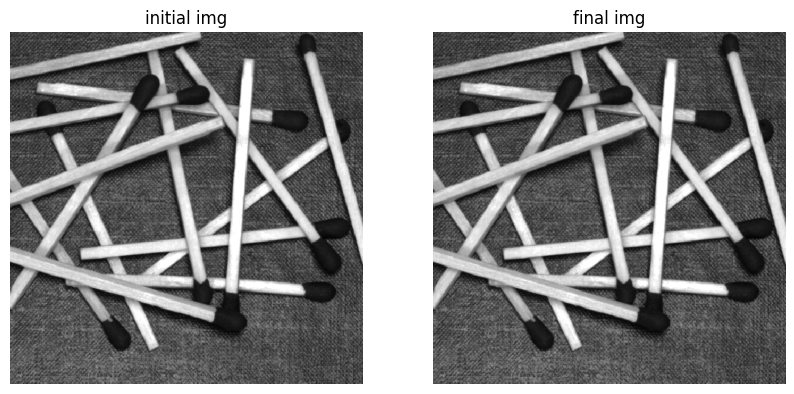

In [31]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(img, cmap='gray')
axs[0].set_title('initial img')
axs[0].axis('off')
axs[1].imshow(img_final, cmap='gray')
axs[1].set_title('final img')
axs[1].axis('off')

In [32]:
np.array_equal(img, img_final)

True